In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
model_name = "../model/trained_cUNet_pytorch_regression_complete_dataset_200epochs_coeff_mask0.75_validation.pkl"

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

In [15]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset,
                                                    validation_split=0.2,
                                                    test_split=0.2,
                                                    batch=16,
                                                    workers=4)

In [16]:
data_lengths

{'train': 5717, 'val': 1429, 'test': 1786}

In [17]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 20, pred_dist: [20.045963]


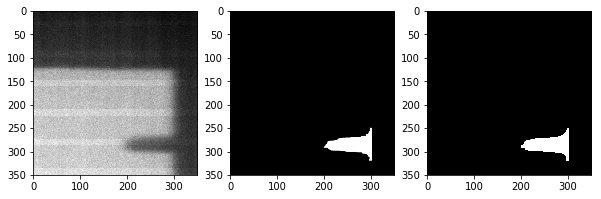

2: true_dist: 1, pred_dist: [0.9849669]


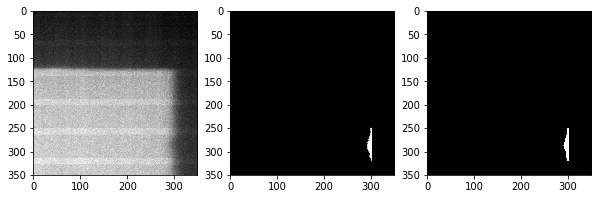

3: true_dist: 4, pred_dist: [3.9688075]


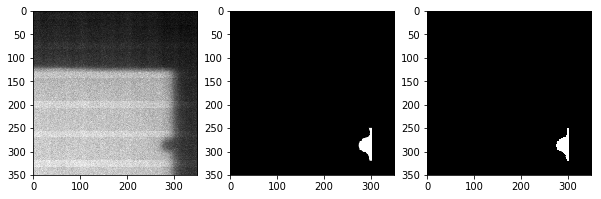

4: true_dist: 4, pred_dist: [3.9746437]


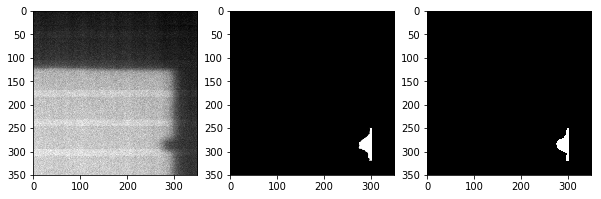

5: true_dist: 30, pred_dist: [30.060278]


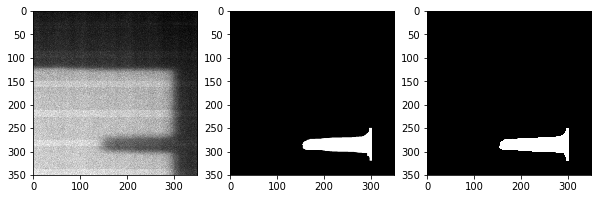

6: true_dist: 25, pred_dist: [25.053812]


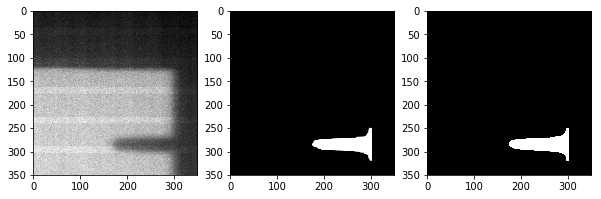

7: true_dist: 1, pred_dist: [0.9931492]


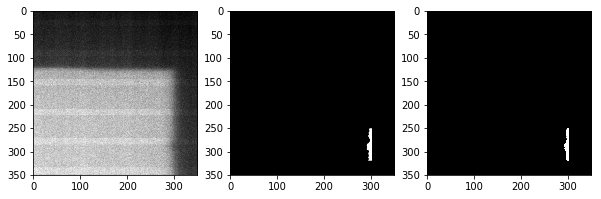

8: true_dist: 35, pred_dist: [35.09231]


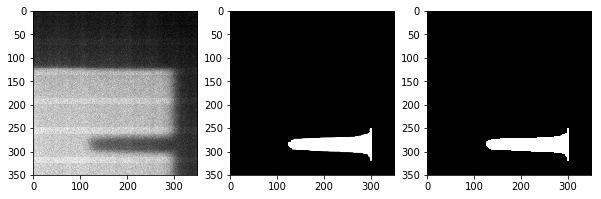

9: true_dist: 2, pred_dist: [1.9803634]


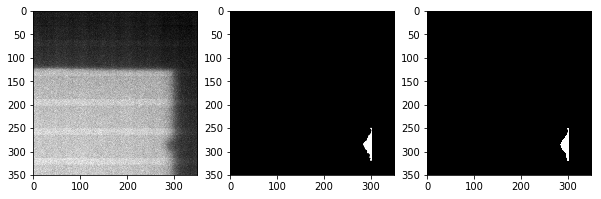

10: true_dist: 35, pred_dist: [35.082233]


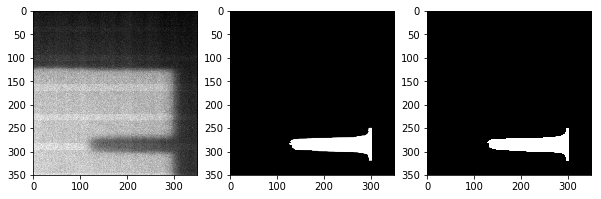

11: true_dist: 3, pred_dist: [2.9245393]


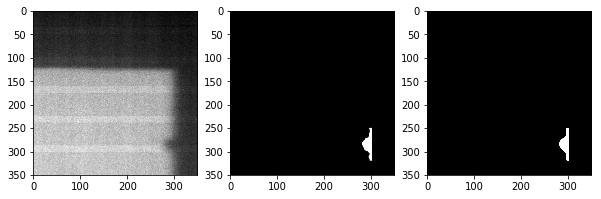

12: true_dist: 25, pred_dist: [25.049952]


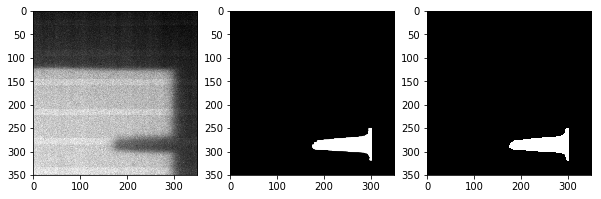

13: true_dist: 3, pred_dist: [2.9966729]


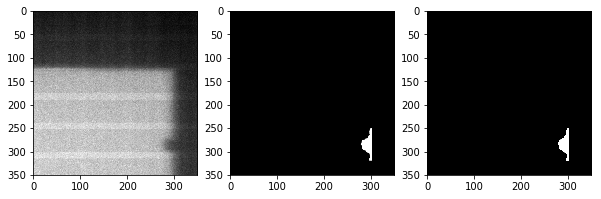

14: true_dist: 15, pred_dist: [15.027888]


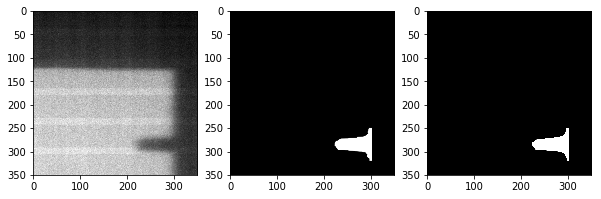

15: true_dist: 20, pred_dist: [20.033394]


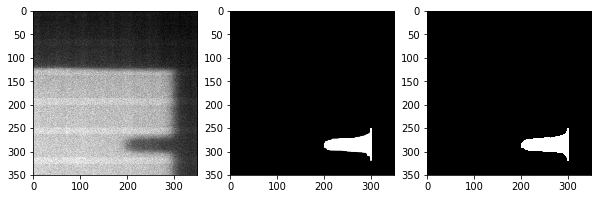

16: true_dist: 30, pred_dist: [30.061846]


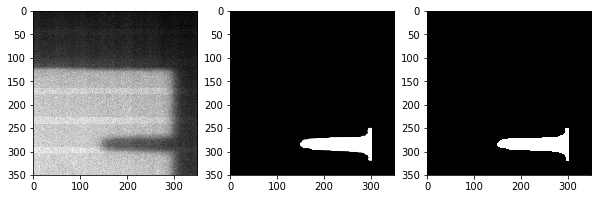

batch 2
1: true_dist: 1, pred_dist: [0.98285955]


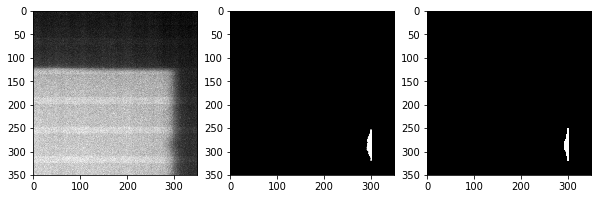

2: true_dist: 15, pred_dist: [15.024198]


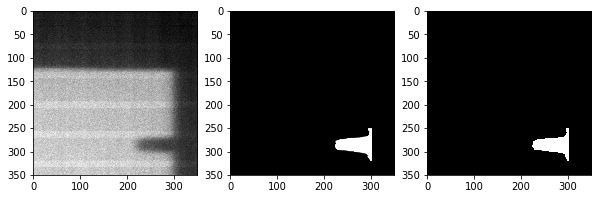

3: true_dist: 4, pred_dist: [3.9812653]


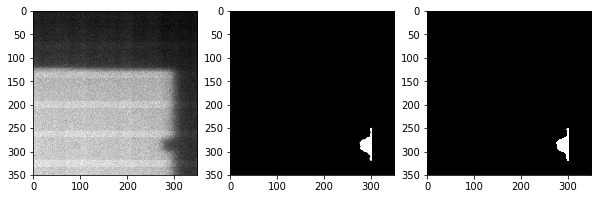

4: true_dist: 20, pred_dist: [20.018848]


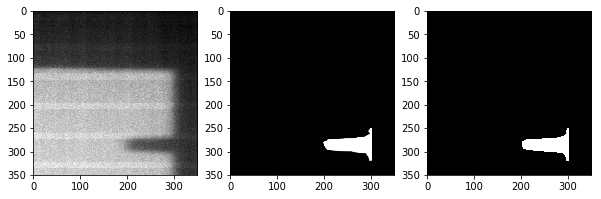

5: true_dist: 25, pred_dist: [25.026207]


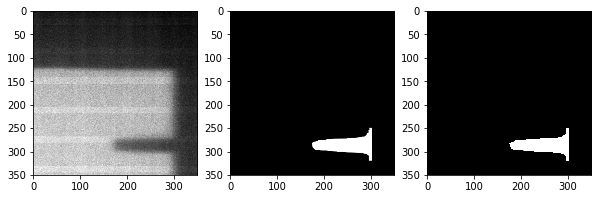

6: true_dist: 3, pred_dist: [2.967535]


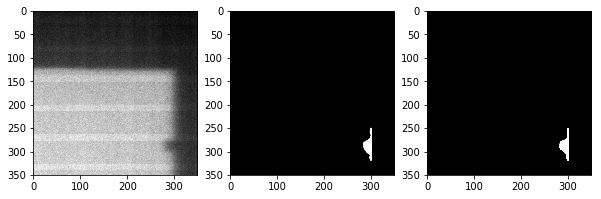

7: true_dist: 30, pred_dist: [30.048994]


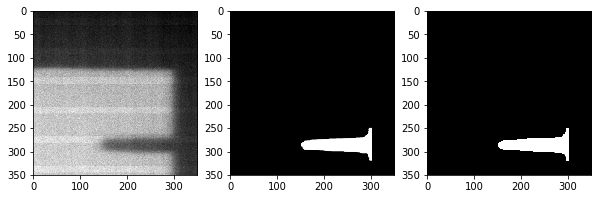

8: true_dist: 4, pred_dist: [4.03388]


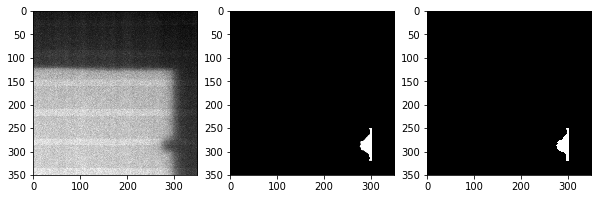

9: true_dist: 10, pred_dist: [10.0197]


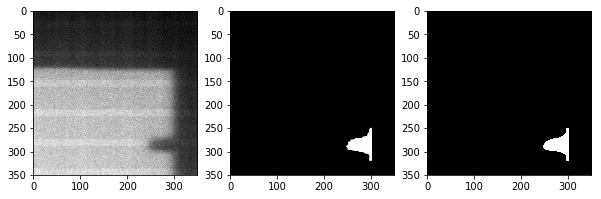

10: true_dist: 15, pred_dist: [15.025775]


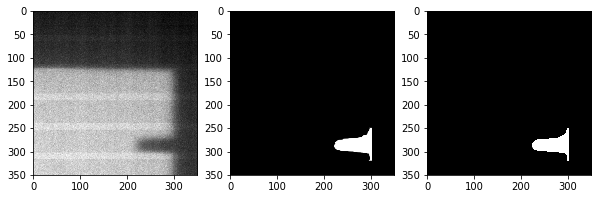

11: true_dist: 15, pred_dist: [15.033427]


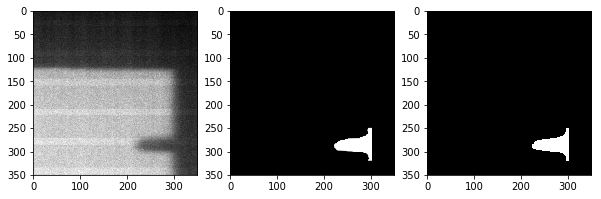

12: true_dist: 2, pred_dist: [2.0039177]


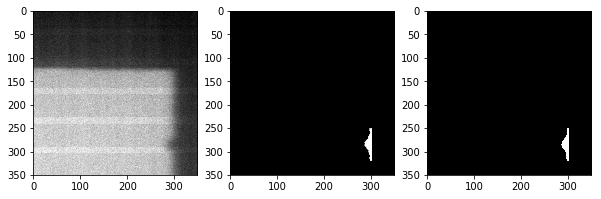

13: true_dist: 2, pred_dist: [1.9921496]


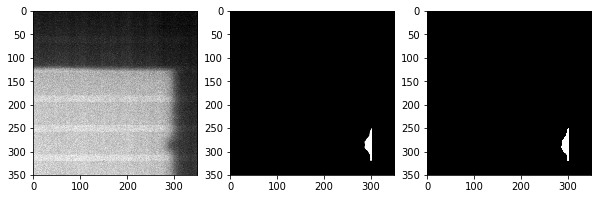

14: true_dist: 10, pred_dist: [10.006404]


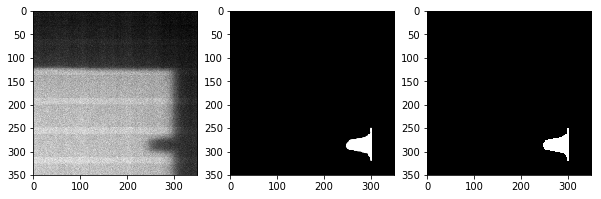

15: true_dist: 1, pred_dist: [0.9964244]


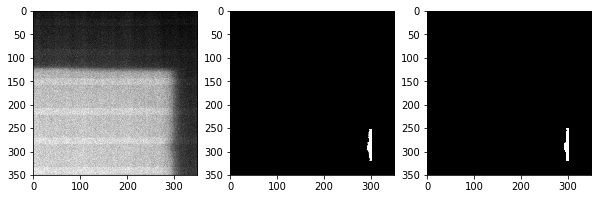

16: true_dist: 20, pred_dist: [20.043081]


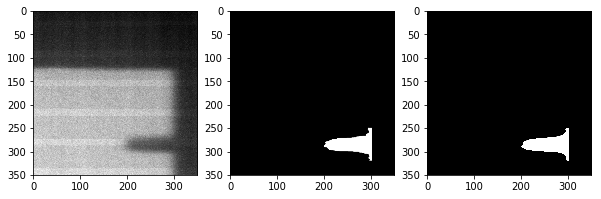

In [18]:
for i, batch in enumerate(data_loaders['test']):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [18]:
batch_size=16

In [19]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders['test']), total = data_lengths['test']//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [20]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.001700470565881265


In [21]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [22]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [23]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.0005161794125963069
2 0.0007478096286207158
3 0.0013844352281814432
4 0.0009065181467262311
10 0.00019470792354152124
15 0.0006393873829229809
20 0.0012454473779345992
25 0.002111379132107094
30 0.0031166688165031983
35 0.0062329606582270675


In [24]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [25]:
errors = [idx_mse(i)[1] for i in distances]

1 0.0005161794125963069
2 0.0007478096286207158
3 0.0013844352281814432
4 0.0009065181467262311
10 0.00019470792354152124
15 0.0006393873829229809
20 0.0012454473779345992
25 0.002111379132107094
30 0.0031166688165031983
35 0.0062329606582270675


(0, 0.05)

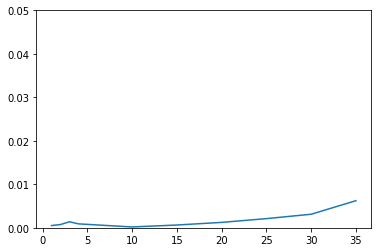

In [26]:
plt.plot(distances, errors)
plt.ylim((0,0.05))

In [27]:
np.savez_compressed("Predicted_ALL_out_model_trained_on_ALLDATA_200_epochs.npz", true=y_true, pred = y_pred)